In [1]:
# Load packages and functions
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
    if (!require(lib, character.only = TRUE, quietly = TRUE)) {
        install.packages(lib, repos='http://cran.us.r-project.org')
    }
}

(.packages())

source("./my_R_functions/utility_functions.R")
source("./my_R_functions/stat_functions.R")
source("./my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

# Load the stats dataframe
load("/ssd/mrichard/data/motifOnlyAllStats.Rdata") #all.stats.df

# Load the boosted model
gbdt_medium <- xgb.load("saved_models/xgboost_TF_site_predict_motif_only.model")

# Load the data and create the training/testing data
# Load the motif data and the big dataset, plus make the names better
load("./Rdata_files/motif_class_pairs.Rdata")
load("/ssd/mrichard/data/joined.annotated.9.Rdata") # Takes ~2 min to load
colnames(all.TF.df.fimo.hint.well.annotated) <- make.names(colnames(all.TF.df.fimo.hint.well.annotated), unique=TRUE)

# Filter the entries w/o fp or hits
all.TF.df.fimo.hint.well.annotated %>%
    filter(h_frac_16 > 0 | w_frac_16 > 0 | h_frac_20 > 0 | w_frac_20 > 0 | cs_hit > 0) ->
        df_only_footprint_hits

# Remove columns we don't need for this part, then drop the original data
# Include the HINT/Wellington columns
cols_to_drop <- c('motifname', 'chrom', 'strand', 'loc',
                  'h_frac_16', 'h_frac_20', 'h_max_score_16', 'h_max_score_20',
                  'w_frac_16', 'w_frac_20', 'w_min_score_16', 'w_min_score_20')

df_only_footprint_hits %>%
    filter(chrom %in% c("2","4")) %>%
    select(-one_of(cols_to_drop)) ->
    val_df

df_only_footprint_hits %>%
    filter(chrom %in% c("1","3","5")) %>%
    select(-one_of(cols_to_drop)) ->
    test_df

df_only_footprint_hits %>%
    filter(!(chrom %in% c("1","2","3","4","5"))) %>%
    select(-one_of(cols_to_drop)) ->
    train_df

remove(df_only_footprint_hits, all.TF.df.fimo.hint.well.annotated)

# Divide into train/test/validation sets and split X/Y
val_df %>%
    select(-cs_hit) %>%
    as.matrix ->
    X_val

val_df %>%
    select(cs_hit) %>%
    as.matrix ->
    y_val

test_df %>%
    select(-cs_hit) %>%
    as.matrix ->
    X_test

test_df %>%
    select(cs_hit) %>%
    as.matrix ->
    y_test

train_df %>%
    select(-cs_hit) %>%
    as.matrix ->
    X_train

train_df %>%
    select(cs_hit) %>%
    as.matrix ->
    y_train

remove(val_df, test_df, train_df)

Loaded glmnet 2.0-12


Attaching package: ‘dplyr’

The following object is masked from ‘package:xgboost’:

    slice

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:glmnet’:

    auc

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



[1] "caTools"      "caret"        "lattice"      "stringr"      "ROCR"        
 [6] "gplots"       "pROC"         "tidyr"        "dplyr"        "glmnet"      
[11] "foreach"      "Matrix"       "xgboost"      "ggplot2"      "RColorBrewer"
[16] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[21] "methods"      "base"

Loading required package: DBI
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:pROC’:

    var

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, len

In [14]:
# Change labels and print out MCC
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm small'] <- 'linear model (all regressors)'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'trees with classes'] <- 'gradient boosted model'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm gc_content'] <- 'GC content'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm motifscore'] <- 'motif score'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm asinh_tss_dist'] <- 'arcsinh(TSS distance)'

max(all.stats.df$MattCC)

[1] 0.4059648

In [15]:
# Create custom color palette (matches joined!)
myPalette <- c("black","red","blue","green2","darkorange","purple","magenta","brown","cyan")
myColors <- myPalette[c(1,2,7,8,9)]
names(myColors) <- c('gradient boosted model',
                     'linear model (all regressors)',
                     'GC content',
                     'motif score',
                     'arcsinh(TSS distance)'
                    )
colScale <- scale_colour_manual(name = "Model.Name",values = myColors)

In [16]:
# Reorder model names
all.stats.df$Model.Name <- factor(all.stats.df$Model.Name,
                                  levels = c('gradient boosted model',
                                             'linear model (all regressors)',
                                             'GC content',
                                             'motif score',
                                             'arcsinh(TSS distance)'
                                            )
                                 )

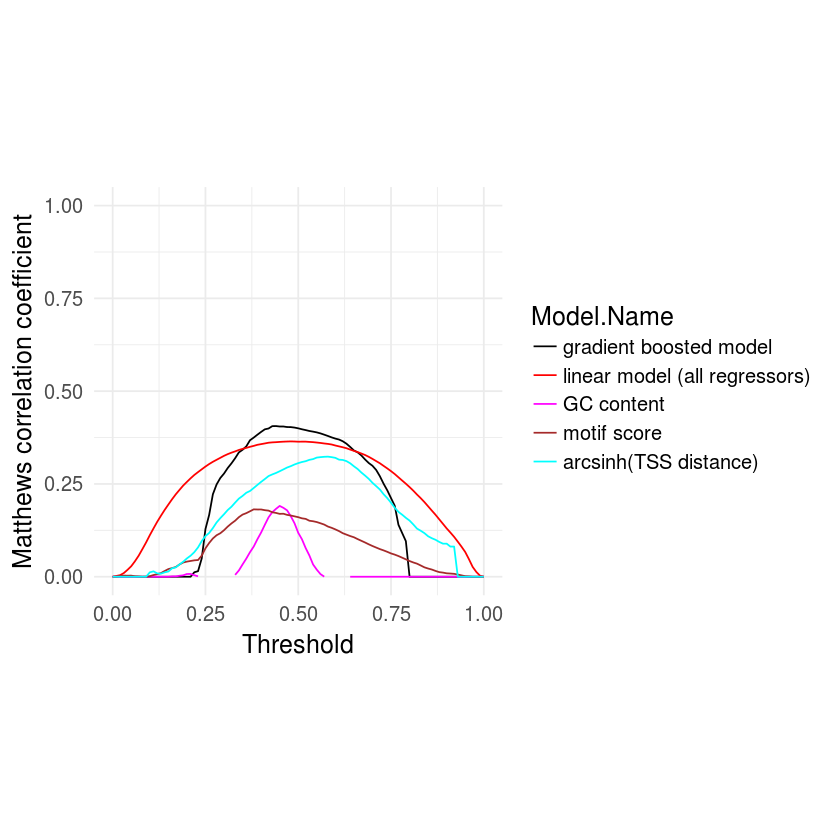

In [17]:
# MCC curves
plot.mattcc.curve(all.stats.df) + theme_minimal(base_size = 15) + colScale

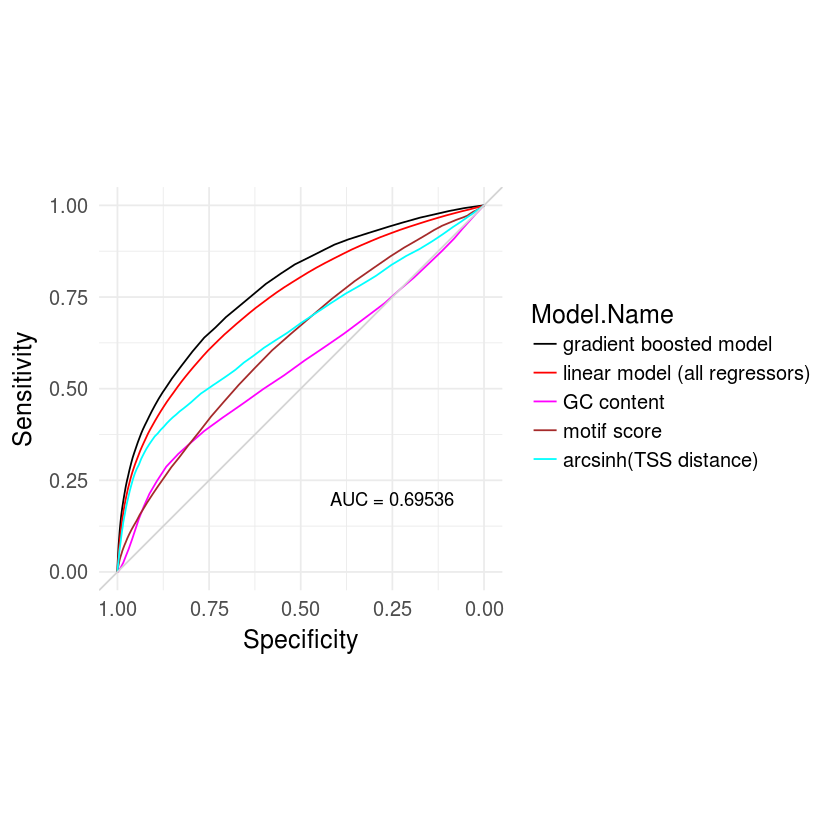

In [18]:
# ROC curves
plot.roc.curve(all.stats.df, TRUE) + theme_minimal(base_size = 15) + colScale

Warning message:
“Removed 34 rows containing missing values (geom_path).”

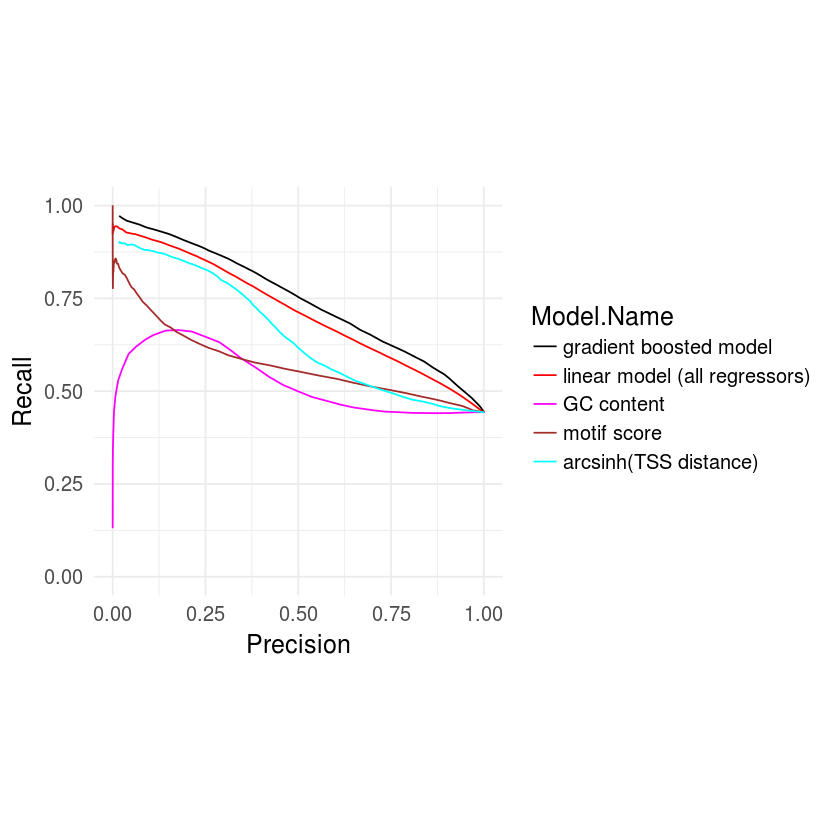

In [19]:
# Precision-Recall curves
plot.precrecall.curve(all.stats.df) + theme_minimal(base_size = 15) + colScale

png 
  2

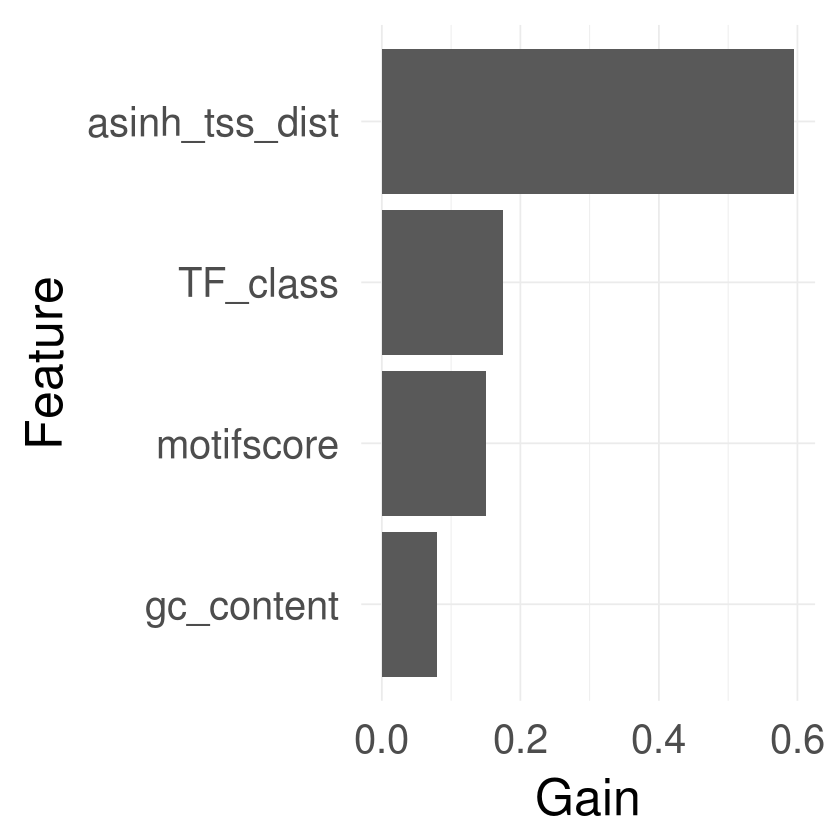

In [20]:
# Importance matrix
motif.class$class <- lapply(motif.class$class, make.names, unique=TRUE)
importance_matrix <- xgb.importance(colnames(X_train),model=gbdt_medium)

# Create importance matrix plot
motif.class$class <- lapply(motif.class$class, make.names, unique=TRUE)
importance_matrix <- xgb.importance(colnames(X_train),model=gbdt_medium)
df <- as_data_frame(importance_matrix)
df.tf <- subset(df, Feature %in% unique(motif.class$class))
df.notf <- subset(df, !(Feature %in% unique(motif.class$class)))
tfclass.row <- c("TF_class", unname(as.list(colSums(df.tf[!(colnames(df.tf) %in% c("Feature"))]))) )
names(tfclass.row) <- colnames(df)
df.sum <- rbind(df.notf,tfclass.row)

ggplot(data=df.sum, aes(x=reorder(Feature, Gain), y=Gain)) +
    geom_bar(stat="identity") +
    coord_flip() +
    theme_minimal(base_size = 30) +
    labs(x = "Feature", y="Gain")

png("../figures/motifOnlyImpMatrix.png")
ggplot(data=df.sum, aes(x=reorder(Feature, Gain), y=Gain)) +
    geom_bar(stat="identity") +
    coord_flip() +
    theme_minimal(base_size = 30) +
    labs(x = "Feature", y="Gain")
dev.off()

In [24]:
png("./figures/motifOnlyMCC.png")
plot.mattcc.curve(all.stats.df) + theme_minimal(base_size = 15) + colScale
dev.off()

png 
  2

In [25]:
png("./figures/motifOnlyROC.png")
plot.roc.curve(all.stats.df, TRUE) + theme_minimal(base_size = 15) + colScale
dev.off()

png 
  2

In [26]:
png("./figures/motifOnlyPreRec.png")
plot.precrecall.curve(all.stats.df) + theme_minimal(base_size = 15) + colScale
dev.off()

Warning message:
“Removed 34 rows containing missing values (geom_path).”

png 
  2